<a href="https://colab.research.google.com/github/Gallifantjack/mit_causal_inference_intro/blob/dev/causal_inference_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIT Intro to Causal Inference 2023

## Credit

- The best resource for getting started is Richard McElreath's outstanding lecture series [Statistical Rethinking 2023](https://www.youtube.com/playlist?list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus).
- The full notebooks have been converted to Python/PyMC 5 by Dustin Stanbury and are available [here](https://github.com/dustinstansbury/statistical-rethinking-2023.git)
- This repository is a consolidation of the notebooks from the above two sources, with some additional notes and exercises.
- The slides for the accompanying lectures are available [here](https://docs.google.com/presentation/d/1MHiFRP7CpvTygIHxfQ_qA4oIt98_8g6kQjJSC6lu1Y8/edit?usp=sharing)

# Set Up

In [2]:
!pip install arviz numpy pandas pymc statsmodels xarray matplotlib scipy graphviz networkx -q

In [3]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.formula.api as smf
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats as stats
import os
import graphviz as gr
import networkx as nx

In [4]:
from pathlib import Path
from typing import List, Union, Callable

def load_data(dataset, delimiter=";"):
    fname = f"{dataset}.csv"
    data_path = HERE / "data"
    data_file = data_path / fname
    return pd.read_csv(data_file, sep=delimiter)


def crosstab(x: np.array, y: np.array, labels: list[str] = None):
    """Simple cross tabulation of two discrete vectors x and y"""
    ct = pd.crosstab(x, y)
    if labels:
        ct.index = labels
        ct.columns = labels
    return ct


def center(vals: np.ndarray) -> np.ndarray:
    return vals - np.nanmean(vals)


def standardize(vals: np.ndarray) -> np.ndarray:
    centered_vals = center(vals)
    return centered_vals / np.nanstd(centered_vals)


def convert_to_categorical(vals):
    return vals.astype("category").cat.codes.values


def logit(p: float) -> float:
    return np.log(p / (1 - p))


def invlogit(x: float) -> float:
    return 1 / (1 + np.exp(-x))


def draw_causal_graph(
    edge_list, node_props=None, edge_props=None, graph_direction="UD"
):
    """Utility to draw a causal (directed) graph"""
    g = gr.Digraph(graph_attr={"rankdir": graph_direction})

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g


def plot_scatter(xs, ys, **scatter_kwargs):
    """Draw scatter plot with consistent style (e.g. unfilled points)"""
    defaults = {"alpha": 0.6, "lw": 3, "s": 80, "color": "C0", "facecolors": "none"}

    for k, v in defaults.items():
        val = scatter_kwargs.get(k, v)
        scatter_kwargs[k] = val

    plt.scatter(xs, ys, **scatter_kwargs)


def plot_line(xs, ys, **plot_kwargs):
    """Plot line with consistent style (e.g. bordered lines)"""
    linewidth = plot_kwargs.get("linewidth", 3)
    plot_kwargs["linewidth"] = linewidth

    # Copy settings for background
    background_plot_kwargs = {k: v for k, v in plot_kwargs.items()}
    background_plot_kwargs["linewidth"] = linewidth + 2
    background_plot_kwargs["color"] = "white"
    del background_plot_kwargs["label"]  # no legend label for background

    plt.plot(xs, ys, **background_plot_kwargs, zorder=30)
    plt.plot(xs, ys, **plot_kwargs, zorder=31)


def plot_errorbar(
    xs, ys, error_lower, error_upper, colors="C0", error_width=12, alpha=0.3
):
    if isinstance(colors, str):
        colors = [colors] * len(xs)

    """Draw thick error bars with consistent style"""
    for ii, (x, y, err_l, err_u) in enumerate(zip(xs, ys, error_lower, error_upper)):
        marker, _, bar = plt.errorbar(
            x=x,
            y=y,
            yerr=np.array((err_l, err_u))[:, None],
            ls="none",
            color=colors[ii],
            zorder=1,
        )
        plt.setp(bar[0], capstyle="round")
        marker.set_fillstyle("none")
        bar[0].set_alpha(alpha)
        bar[0].set_linewidth(error_width)


def plot_x_errorbar(
    xs, ys, error_lower, error_upper, colors="C0", error_width=12, alpha=0.3
):
    if isinstance(colors, str):
        colors = [colors] * len(xs)

    """Draw thick error bars with consistent style"""
    for ii, (x, y, err_l, err_u) in enumerate(zip(xs, ys, error_lower, error_upper)):
        marker, _, bar = plt.errorbar(
            x=x,
            y=y,
            xerr=np.array((err_l, err_u))[:, None],
            ls="none",
            color=colors[ii],
            zorder=1,
        )
        plt.setp(bar[0], capstyle="round")
        marker.set_fillstyle("none")
        bar[0].set_alpha(alpha)
        bar[0].set_linewidth(error_width)


def plot_graph(graph, **graph_kwargs):
    """Draw a network graph.

    graph: Union[networkx.DiGraph, np.ndarray]
        if ndarray, assume `graph` is an adjacency matrix defining
        a directed graph.

    """
    # convert to networkx.DiGraph, if needed
    G = (
        nx.from_numpy_array(graph, create_using=nx.DiGraph)
        if isinstance(graph, np.ndarray)
        else graph
    )

    # Set default styling
    np.random.seed(123)  # for consistent spring-layout
    if "layout" in graph_kwargs:
        graph_kwargs["pos"] = graph_kwargs["layout"](G)

    default_graph_kwargs = {
        "node_color": "C0",
        "node_size": 500,
        "arrowsize": 30,
        "width": 3,
        "alpha": 0.7,
        "connectionstyle": "arc3,rad=0.1",
        "pos": nx.kamada_kawai_layout(G),
    }
    for k, v in default_graph_kwargs.items():
        if k not in graph_kwargs:
            graph_kwargs[k] = v

    nx.draw(G, **graph_kwargs)
    # return the node layout for consistent graphing
    return graph_kwargs["pos"]


def plot_2d_function(xrange, yrange, func, ax=None, **countour_kwargs):
    """Evaluate the function `func` over the values of xrange and yrange and
    plot the resulting value contour over that range.

    Parameters
    ----------
    xrange : np.ndarray
        The horizontal values to evaluate/plot
    yrange : p.ndarray
        The horizontal values to evaluate/plot
    func : Callable
        function of two arguments, xs and ys. Should return a single value at
        each point.
    ax : matplotlib.Axis, optional
        An optional axis to plot the function, by default None

    Returns
    -------
    contour : matplotlib.contour.QuadContourSet
    """
    resolution = len(xrange)
    xs, ys = np.meshgrid(xrange, yrange)
    xs = xs.ravel()
    ys = ys.ravel()

    value = func(xs, ys)

    if ax is not None:
        plt.sca(ax)

    return plt.contour(
        xs.reshape(resolution, resolution),
        ys.reshape(resolution, resolution),
        value.reshape(resolution, resolution),
        **countour_kwargs,
    )


def create_variables_dataframe(*variables: List[np.ndarray]) -> pd.DataFrame:
    """Converts a list of numpy arrays to a dataframe; infers column names from
    variable names
    """
    column_names = [get_variable_name(v) for v in variables]
    return pd.DataFrame(np.vstack(variables).T, columns=column_names)


def plot_pymc_distribution(distribution: pm.Distribution, **distribution_params):
    """Plot a PyMC Distribution with specific distrubution parameters

    Parameters
    ----------
    distribution : pymc.Distribution
        The class of distribution to
    **distribution_params : dict
        Distribution-specific parameters.

    Returns
    -------
    ax : matplotlib.Axes
        The axes object associated with the plot.
    """
    with pm.Model() as _:
        d = distribution(name=distribution.__name__, **distribution_params)
        draws = pm.draw(d, draws=10_000)
    return az.plot_dist(draws)


def savefig(filename):
    """Save a figure to the `./images` directory"""
    image_path = HERE / "images"
    if not image_path.exists():
        print(f"creating image directory: {image_path}")
        os.makedirs(image_path)

    figure_path = image_path / filename
    print(f"saving figure to {figure_path}")
    plt.savefig(figure_path, dpi=300, bbox_inches="tight")


def display_image(filename, width=600):
    """Display an image saved to the `./images` directory"""
    from IPython.display import Image, display

    return display(Image(filename=f"images/{filename}", width=width))


def simulate_2_parameter_bayesian_learning(
    x_obs,
    y_obs,
    param_a_grid,
    param_b_grid,
    true_param_a,
    true_param_b,
    model_func,
    posterior_func,
    n_posterior_samples=3,
    param_labels=None,
    data_range_x=None,
    data_range_y=None,
):
    """General function for simulating Bayesian learning in a 2-parameter model
    using grid approximation.

    Parameters
    ----------
    x_obs : np.ndarray
        The observed x values
    y_obs : np.ndarray
        The observed y values
    param_a_grid: np.ndarray
        The range of values the first model parameter in the model can take.
        Note: should have same length as param_b_grid.
    param_b_grid: np.ndarray
        The range of values the second model parameter in the model can take.
        Note: should have same length as param_a_grid.
    true_param_a: float
        The true value of the first model parameter, used for visualizing ground
        truth
    true_param_b: float
        The true value of the second model parameter, used for visualizing ground
        truth
    model_func: Callable
        A function `f` of the form `f(x, param_a, param_b)`. Evaluates the model
        given at data points x, given the current state of parameters, `param_a`
        and `param_b`. Returns a scalar output for the `y` associated with input
        `x`.
    posterior_func: Callable
        A function `f` of the form `f(x_obs, y_obs, param_grid_a, param_grid_b)
        that returns the posterior probability given the observed data and the
        range of parameters defined by `param_grid_a` and `param_grid_b`.
    n_posterior_samples: int
        The number of model functions sampled from the 2D posterior
    param_labels: Optional[list[str, str]]
        For visualization, the names of `param_a` and `param_b`, respectively
    data_range_x: Optional len-2 float sequence
        For visualization, the upper and lower bounds of the domain used for model
        evaluation
    data_range_y: Optional len-2 float sequence
        For visualization, the upper and lower bounds of the range used for model
        evaluation.
    """
    param_labels = param_labels if param_labels is not None else ["param_a", "param_b"]
    data_range_x = (x_obs.min(), x_obs.max()) if data_range_x is None else data_range_x
    data_range_y = (y_obs.min(), y_obs.max()) if data_range_y is None else data_range_y

    # NOTE: assume square parameter grid
    resolution = len(param_a_grid)

    param_a_grid, param_b_grid = np.meshgrid(param_a_grid, param_b_grid)
    param_a_grid = param_a_grid.ravel()
    param_b_grid = param_b_grid.ravel()

    posterior = posterior_func(x_obs, y_obs, param_a_grid, param_b_grid)

    # Visualization
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot Posterior over intercept and slope params
    plt.sca(axs[0])
    plt.contour(
        param_a_grid.reshape(resolution, resolution),
        param_b_grid.reshape(resolution, resolution),
        posterior.reshape(resolution, resolution),
        cmap="gray_r",
    )

    # Sample locations in parameter space according to posterior
    sample_idx = np.random.choice(
        np.arange(len(posterior)),
        p=posterior / posterior.sum(),
        size=n_posterior_samples,
    )

    param_a_list = []
    param_b_list = []
    for ii, idx in enumerate(sample_idx):
        param_a = param_a_grid[idx]
        param_b = param_b_grid[idx]
        param_a_list.append(param_a)
        param_b_list.append(param_b)

        # Add sampled parameters to posterior
        plt.scatter(param_a, param_b, s=60, c=f"C{ii}", alpha=0.75, zorder=20)

    # Add the true params to the plot for reference
    plt.scatter(
        true_param_a, true_param_b, color="k", marker="x", s=60, label="true parameters"
    )

    plt.xlabel(param_labels[0])
    plt.ylabel(param_labels[1])

    # Plot the current training data and model trends sampled from posterior
    plt.sca(axs[1])
    plt.scatter(x_obs, y_obs, s=60, c="k", alpha=0.5)

    # Plot the resulting model functions sampled from posterior
    xs = np.linspace(data_range_x[0], data_range_x[1], 100)
    for ii, (param_a, param_b) in enumerate(zip(param_a_list, param_b_list)):
        ys = model_func(xs, param_a, param_b)
        plt.plot(xs, ys, color=f"C{ii}", linewidth=4, alpha=0.5)

    groundtruth_ys = model_func(xs, true_param_a, true_param_b)
    plt.plot(
        xs, groundtruth_ys, color="k", linestyle="--", alpha=0.5, label="true trend"
    )

    plt.xlim([data_range_x[0], data_range_x[1]])
    plt.xlabel("x value")

    plt.ylim([data_range_y[0], data_range_y[1]])
    plt.ylabel("y value")

    plt.title(f"N={len(y_obs)}")
    plt.legend(loc="upper left")

# Elemental Confounds

In [5]:
"""Helper functions for displaying elemental confounds"""

def summarize_discrete_counfound_simulation(X, Y, Z):
    print(f'Correlation between X and Y: {np.corrcoef(X, Y)[0, 1]:1.2}')
    print("Cross tabulation:")
    print(crosstab(X, Y, labels=['X', 'Y']))

    for z in [0, 1]:
        X_z = X[Z==z]
        Y_z = Y[Z==z]

        print(f'\nCorrelation between X and Y conditioned on Z={z}: {np.corrcoef(X_z, Y_z)[0, 1]:1.2f}')
        print("Cross tabulation:")
        print(crosstab(X_z, Y_z, labels=['X', 'Y']))

def fit_linear_models_to_simulated_data(data):
    models = {}
    models['unstratified'] = smf.ols("Y ~ X", data=data).fit()

    # Stratified Models
    for z in [0, 1]:
        models[f'Z={z}'] = smf.ols("Y ~ X", data=data[data.Z==z]).fit()
    return models

def plot_sms_linear_model_fit(model, xs, label, color):
    """Helper function to plot linear models"""
    params = model.params
    ys = params.Intercept + params.X * xs
    return plot_line(xs, ys, label=label, color=color)

def plot_continuous_confound_simulation(data, title):
    """Helper function to plot simulations"""
    models = fit_linear_models_to_simulated_data(data)
    plt.subplots(figsize=(6, 6))

    xs = np.linspace(-4, 4, 20)
    for z in [0, 1]:
        color = f"C{np.abs(z - 1)}"  # Note: flip colormap
        plot_scatter(data[data.Z==z].X, data[data.Z==z].Y, color=color);
        plot_sms_linear_model_fit(models[f'Z={z}'], xs, label=f'Z={z}', color=color)

    plot_sms_linear_model_fit(models['unstratified'], xs, label='total sample', color='black')

    plt.xlabel("X")
    plt.ylabel("Y")

    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.legend();
    plt.title(title)

## The Fork $X \leftarrow Z \rightarrow Y$
- $Χ$ and $Y$ share "common cause" $Z$
- common cause $Z$ induces an association between $Χ$ and $Y$
  - $X \not \perp Y$
- once stratified by $Z$, no association between $Χ$ and $Y$ **for each level of $Z$**
  -  $X \perp Y | Z$

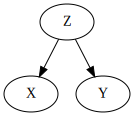

In [6]:
draw_causal_graph(
    edge_list=[
        ("Z", "X"), ("Z", "Y")
    ],
)

Note. If $Z$ was the _only_ common cause, $X$ and $Y$ would be clones of one another. There are other non-modeled/unobserved influences of $X$ and $Y$--often referred to as error terms $e_{X,Y}$ that are not included in the graph above, but nonetheless are causing the difference between $X$ and $Y$, and should be modeled, often as noise  in any generative model.

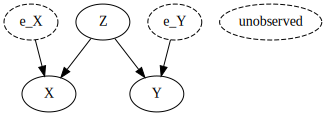

In [7]:
draw_causal_graph(
    edge_list=[
        ("Z", "X"), ("Z", "Y"), ("e_X", "X"), ("e_Y", "Y")
    ],
    node_props={
        "e_X": {"style": "dashed"},
        "e_Y": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    }
)

## Fork Generative Process: Discrete Example
Below we simulate a Fork generative process:

$$
\begin{align*}
Z &\sim \text{Bernoulli}(0.5) \\
X &\sim \text{Bernoulli}(p*) \\
Y &\sim \text{Bernoulli}(p*) \\
p^* &= 0.9 \times Z + 0.1 \times (1 - Z) \\
\end{align*}
$$

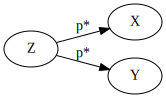

In [8]:
draw_causal_graph(
    edge_list=[
        ("Z", "X"),
        ("Z", "Y")
    ],
    edge_props={
        ("Z", "X"): {"label": "p*"},
        ("Z", "Y"): {"label": "p*"}
    },
    graph_direction="LR"
)

In [9]:
# Discrete Fork
np.random.seed(321)
n_samples = 1000
Z = stats.bernoulli.rvs(p=.5, size=n_samples)
p_star = Z * .9 + (1 - Z) * .1
X = stats.bernoulli.rvs(p=p_star)
Y = stats.bernoulli.rvs(p=p_star)

Show that:
- $X \not\!\perp Y$
- $X \perp Y | Z$

In [10]:
summarize_discrete_counfound_simulation(X, Y, Z)

Correlation between X and Y: 0.63
Cross tabulation:
     X    Y
X  412  101
Y   86  401

Correlation between X and Y conditioned on Z=0: -0.02
Cross tabulation:
     X   Y
X  407  49
Y   41   4

Correlation between X and Y conditioned on Z=1: -0.01
Cross tabulation:
    X    Y
X   5   52
Y  45  397


**There is a strong correlation between X & Y in the first case, but when we stratify by Z (Z=0 or Z=1) the correlation goes to 0**

## Fork Generative Process: Continuous Example

$$
\begin{align*}
Z &\sim \text{Bernoulli}(0.5) \\
X &\sim \text{Normal}(Z, \sigma^2) \\
Y &\sim \text{Normal}(Z, \sigma^2) \\
\mu^* &= 2Z -1 \\
\sigma^2 &= 1 \\
\end{align*}
$$

In [11]:
# Continous Fork
np.random.seed(1234)
n_samples = 400

Z = stats.bernoulli.rvs(p=.5, size=n_samples)

mu_star = 2 * Z - 1
X = stats.norm.rvs(loc=mu_star, size=n_samples)
Y = stats.norm.rvs(loc=mu_star, size=n_samples)

# Put simulated data into dataframe for statsmodels API
fork_data = pd.DataFrame(np.vstack([Z, X, Y]).T, columns=['Z', 'X', 'Y'])

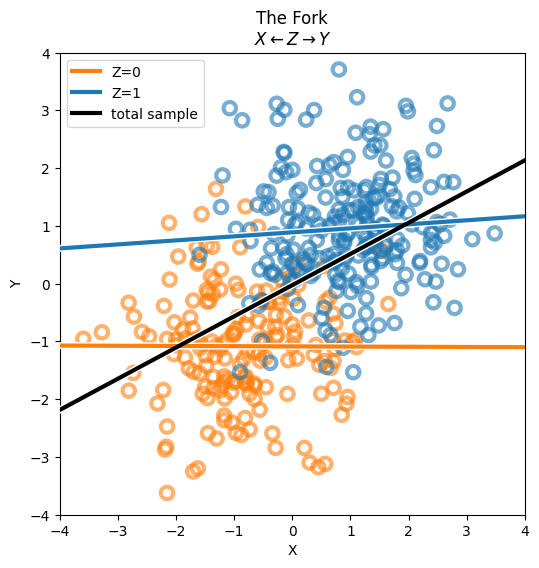

In [12]:
plot_continuous_confound_simulation(fork_data, "The Fork\n$X \\leftarrow Z \\rightarrow Y$")

**Black line suggests that knowing X tells you something about Y** </br>
**But when we block by Z then this correlation again disappears**

## The Pipe $X \rightarrow Z \rightarrow Y$


- $Z$ is a "mediator" of $Χ$ and $Y$ ($Z$ does not affect $X$)
- The influence of $Χ$ on $Y$ is transmitted through $Z$, thus $X$ and $Y$ are associated
  - $X \not \perp Y$
- once stratified by $Z$, no association between $Χ$ and $Y$ **for each level of $Z$**
  -  $X \perp Y | Z$

- **Statistically very similar to the Fork**
- **Causally very different from the Fork**

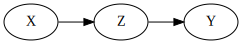

In [13]:
draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "Y")
    ],
    graph_direction="LR"
)

## Discrete Example

Below we simulate a "Pipe" generative process:

$$
\begin{align*}
X &\sim \text{Bernoulli}(0.5) \\
Z &\sim \text{Bernoulli}(p*) \\
Y &\sim \text{Bernoulli}(q*) \\
p^* &= 0.9 \times X + 0.1 \times X \\
q^* &= 0.9 \times Z + 0.1 \times Z \\
\end{align*}
$$

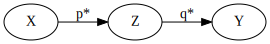

In [14]:
draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "Y")
    ],
    edge_props={
        ("X", "Z"): {"label": "p*"},
        ("Z", "Y"): {"label": "q*"}
    },
    graph_direction="LR"
)

In [15]:
np.random.seed(1234)
n_samples = 1000
X = stats.bernoulli.rvs(p=.5, size=n_samples)

p_star = X * .9 + (1 - X) * .1
Z = stats.bernoulli.rvs(p=p_star, size=n_samples)

q_star = Z * .9 + (1 - Z) * .1
Y = stats.bernoulli.rvs(p=q_star, size=n_samples)

Demonstrate that:
- $X \not \perp Y$
- $X \perp Y | Z$

In [16]:
summarize_discrete_counfound_simulation(X, Y, Z)

Correlation between X and Y: 0.65
Cross tabulation:
     X    Y
X  396   84
Y   89  431

Correlation between X and Y conditioned on Z=0: -0.02
Cross tabulation:
     X   Y
X  392  46
Y   41   4

Correlation between X and Y conditioned on Z=1: -0.01
Cross tabulation:
    X    Y
X   4   38
Y  48  427


**Again stratifying by Z appears to remove the correlation**

### Why does this happen?
 - everything $X$ knows about $Y$, $Z$ knows
 - once you learn about $Z$, there is nothing else to learn about the association between $X$ and $Y$

## Continuous Example

$$
\begin{align*}
X &\sim \text{Normal}(0, 1) \\
Z &\sim \text{Bernoulli}(p*) \\
Y &\sim \text{Bernoulli}(q*) \\
p^* &= \frac{1}{1 + e^{-X}} \\
q^* &= 0.9 \times Z + 0.1 \times Z \\
\end{align*}
$$

In [17]:
np.random.seed(1234)
n_samples = 1000

X = stats.norm.rvs(size=n_samples)
Z = stats.bernoulli.rvs(p=invlogit(X), size=n_samples)

mu_star = 2 * Z - 1
Y = stats.norm.rvs(loc=mu_star, size=n_samples)

pipe_data = pd.DataFrame(np.vstack([Z, X, Y]).T, columns=['Z', 'X', 'Y'])

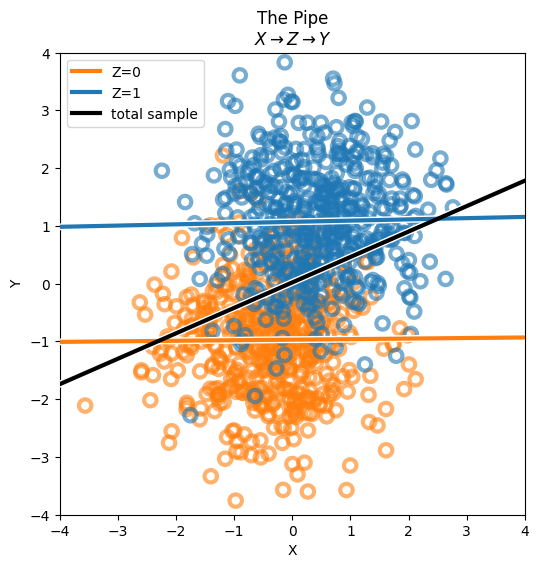

In [18]:
plot_continuous_confound_simulation(pipe_data, "The Pipe\n$X \\rightarrow  Z \\rightarrow Y$")

### Pipe Example: Plant Growth

- Plant growth experiment 100 plants
- Half treated with anti-fungal Measure growth and fungus
- Estimand: Causal effect of treatment on plant growth

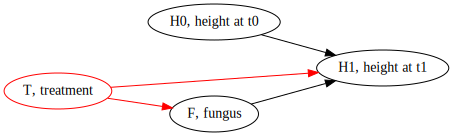

In [19]:
draw_causal_graph(
    [
        ("H0", "H1"),
        ("T", "H1"),
        ("T", "F"),
        ("F", "H1")
    ],
    node_props={
        "T": {"color": "red", "label": "T, treatment"},
        "F": {"label": "F, fungus"},
        "H0": {"label": "H0, height at t0"},
        "H1": {"label": "H1, height at t1"}
    },
    edge_props={
        ("T", "H1"): {"color": "red"},
        ("T", "F"): {"color": "red"},
    },
    graph_direction="LR"
)

### To estimate the **Total Causal Effect** of Treatment, should we Stratify by F?

**NO**
- Stratifying by F would be a bad idea here if we wanted to estimate the total causal effect of T on H1, because of the $T \rightarrow F \rightarrow H1$ pipe in the graph.
- Stratifying by F would block infromation about T's affect on H1 that flow through F.
- NOTE: stratifying by $F$ would give the **Direct Causal Effect** of $T$ on $H1$

This is an example of **post-treatment bias**.
> Rule of Thumb: **consequence of the treatement should not be included in an estimator.**

## The Collider $X \rightarrow Z \leftarrow Y$


- $Z$ _caused jointly_ by $Χ$ and $Y$
- $X$ and $Y$ have no shared causes, thus are not associated
  - $X \perp Y$
- once stratified by $Z$, $Χ$ and $Y$ are now associated
  -  $X \not \perp Y | Z$
  -  stratifying by $Z$ provides information about $X$ and $Y$


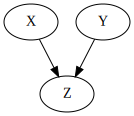

In [20]:
draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Y", "Z")
    ]
)

## Discrete Example

Below we simulate a "Collider" generative process:

$$
\begin{align*}
X &\sim \text{Bernoulli}(0.5) \\
Y &\sim \text{Bernoulli}(0.5) \\
Z &\sim \text{Bernoulli}(p*) \\
p^* &= \begin{cases}
    0.9 ,& \text{if } X + Y \gt 0\\
    0.05,              & \text{otherwise}
\end{cases}
\end{align*}
$$


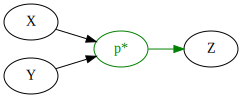

In [21]:
draw_causal_graph(
    edge_list=[
        ("X", "p_star"),
        ("Y", "p_star"),
        ("p_star", "Z")
    ],
    node_props={"p_star": {"label": "p*", "color": "green", "fontcolor": "green"}},
    edge_props={("p_star", "Z"): {"color": "green"}},
    graph_direction="LR"
)

Note: the structure above should not be confused with the "Descendant" discussed later. Here $p^*$ is a determinstic function of $X$ and $Y$ that defines the probability distribution over $Z$, wheras in the Descendant, the  downstream variable (e.g. $A$) "leaks" information about the collider.

In [22]:
np.random.seed(123)
n_samples = 1000

X = stats.bernoulli.rvs(p=.5, size=n_samples)
Y = stats.bernoulli.rvs(p=.5, size=n_samples)

# p(z | x, y)
p_star = np.where(X + Y > 0, 0.9, 0.05)
Z = stats.bernoulli.rvs(p=p_star, size=n_samples)

Demonstrate that:
- $X \perp Y$
- $X \not  \perp Y | Z$

In [23]:
summarize_discrete_counfound_simulation(X, Y, Z)

Correlation between X and Y: -0.052
Cross tabulation:
     X    Y
X  240  268
Y  258  234

Correlation between X and Y conditioned on Z=0: 0.41
Cross tabulation:
     X   Y
X  229  21
Y   23  22

Correlation between X and Y conditioned on Z=1: -0.49
Cross tabulation:
     X    Y
X   11  247
Y  235  212


**Here we get the opposite phenomena to above... there is no correlation until we stratify by z**

## Continuous Example

$$
\begin{align*}
X &\sim \text{Normal}(0, 1) \\
X &\sim \text{Normal}(0, 1) \\
Z &\sim \text{Bernoulli}(p*) \\
p^* &= \frac{1}{1 + e^{-(\alpha + \beta_{XZ}X + \beta_{YZ}Y)}} \\
\end{align*}
$$

In [24]:
np.random.seed(1234)

n_samples = 500
X = stats.norm.rvs(size=n_samples)
Y = stats.norm.rvs(size=n_samples)

beta_XZ = 2
beta_YZ = 2
alpha = -2

p_star = invlogit(alpha + beta_XZ * X + beta_YZ * Y)
Z = stats.bernoulli.rvs(p=p_star)

collider_data = pd.DataFrame(np.vstack([Z, X, Y]).T, columns=['Z', 'X', 'Y'])

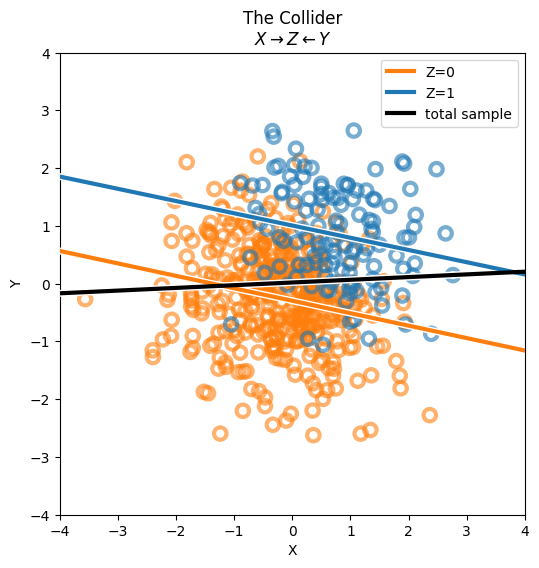

In [25]:
plot_continuous_confound_simulation(collider_data, "The Collider\n$X \\rightarrow  Z \\leftarrow Y$")

- Total sample shows no association
- Stratifying by Z shows negative association

### Why does this happen?

**Thresholding effect**
- If either $X$ OR $Y$ are big enough, it will result in a conditional value (the green deterministic function $p*$ above) that is large enough to associate the sample with $Z=1$.
- Similarly if either $X$ OR $Y$ are small enough, it will associate the sample with $Z=0$.
- If one of those is is hi/low enough while the other is average or lower/larger, this will induce a negative correlation on average.

## Collider Example: Grant Awards
$N \rightarrow A \leftarrow T$
- To be awarded $A$, Grants must be sufficiently either Newsworthy $N$ or Trustworthy $T$
- Few grants are high on both
- results in negative association for awarded grants
- Post-selection bias

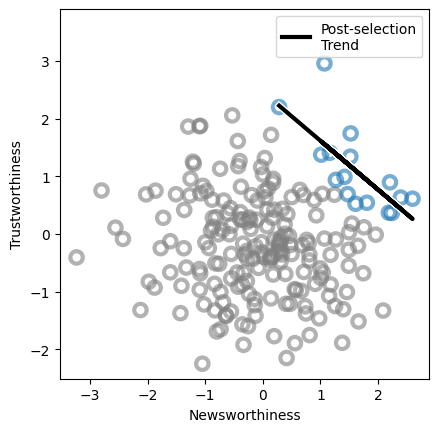

In [26]:
np.random.seed(123)
n_samples = 200

# N and T are independent
N = stats.norm.rvs(size=n_samples)
T = stats.norm.rvs(size=n_samples)

# Award criterion; either are large enough to threshold
A = np.where(N + T > 2, 1, 0)

for awarded in [0, 1]:
    color = 'gray' if not awarded else 'C0'
    N_A = N[A==awarded]
    T_A = T[A==awarded]
    plot_scatter(N_A, T_A, color=color)

awarded_model = smf.ols("T ~ N", data=pd.DataFrame({"N": N_A, "T": T_A})).fit()
plot_line(N_A, awarded_model.predict(), color='k', label='Post-selection\nTrend')
plt.xlabel("Newsworthiness")
plt.ylabel("Trustworthiness")
plt.axis("square")
plt.legend();

## Example: Age, Happiness, and Marriage

$A \rightarrow M \leftarrow H$

- The older you are, the more changes of being married
- The happier you are, the more amicable you are, and thus are more likely to have another person marry you
- Here, **age does not influence happiness**, they are independent

Below is a janky version of the simulation in the lecture. Rather than running the termporal simulation, starting at age 18,
and sampling marital status for each happiness level at each point in time, we just do the whole simulation in one sample, modeling the probability of being married as a combination of both Age $A$ and Happiness $H$: $p_{married} = \text{invlogit}(\beta_H (\bar H - 18) + \beta_A A)$

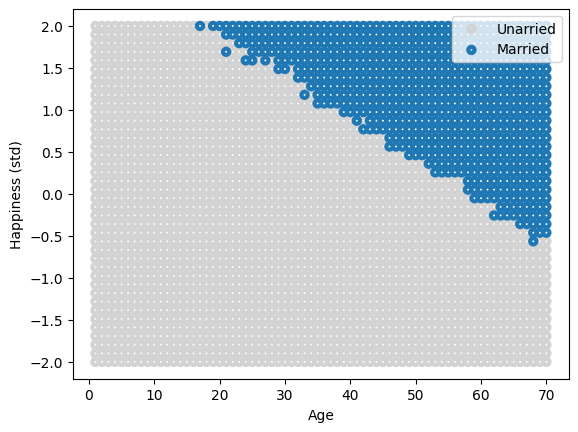

In [27]:
age = np.arange(1, 71)
happiness = np.linspace(-2, 2, 40)
age_grid, happiness_grid = np.meshgrid(age, happiness)

# Arbitrary
beta_happiness = 20
beta_age = 1
min_marriage_age = 18

age_grid = age_grid.ravel()
happiness_grid = happiness_grid.ravel()
married_grid = []
for a, h in zip(age_grid, happiness_grid):
    p_marriage = invlogit(h * beta_happiness + (a - 40 - 18) * beta_age)
    married_grid.append(stats.bernoulli(p=p_marriage).rvs())

married_grid = np.array(married_grid).astype(int)

plot_scatter(age_grid[married_grid==0], happiness_grid[married_grid==0], s=20, alpha=1, color='lightgray', label='Unarried')
plot_scatter(age_grid[married_grid==1], happiness_grid[married_grid==1], s=20, alpha=1, color='C0', label='Married')
plt.xlabel("Age")
plt.ylabel("Happiness (std)")
plt.legend();


If we were to stratify by married folks only ($M=1$), we would conclude that Age and Happiness are negatively associated, despite them actually being independent in this simulation.

## Collider Example: Restaurant Success

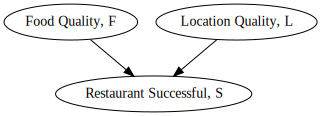

In [28]:
draw_causal_graph(
    edge_list=[
        ("F", "S"),
        ("L", "S")
    ],
    node_props={
        "F": {"label": "Food Quality, F"},
        "L": {"label": "Location Quality, L"},
        "S": {"label": "Restaurant Successful, S"}
    }
)

#### Simulate Restaurant Success

$$
\begin{align*}
S &\sim \text{Bernoulli}(p_S) \\
p_S &= \text{invlogit}(\alpha+ \beta_Q Q + \beta_L L) \\
\end{align*}
$$

In [29]:
np.random.seed(123)
n_restaurants = 1000
food_quality = stats.norm.rvs(size=n_restaurants)  # standardized food quality
location_quality = stats.norm.rvs(size=n_restaurants)  # standardized quality of restaurant location

beta_food_quality = 20  # good food increases probability of success
beta_location_quality = 20  # good location also increases probability of success
intercept = -40  # the average restaurant will not succeed

p_success = invlogit(
    food_quality * beta_food_quality + location_quality * beta_location_quality + intercept
)
stays_in_business = stats.bernoulli.rvs(p_success)

data = data = pd.DataFrame(
    np.vstack(
        [location_quality, food_quality, stays_in_business]
    ).T,
    columns=['location_quality', 'food_quality', 'stays_in_business']
)

In [30]:
models = {}
models['unstratified'] = smf.ols("food_quality ~ location_quality", data=data).fit()

# Stratified Models (post-hoc selection based on successful business)
models['business_failed'] = smf.ols("food_quality ~ location_quality", data=data[data.stays_in_business==0]).fit()
models['business_succeeded'] = smf.ols("food_quality ~ location_quality", data=data[data.stays_in_business==1]).fit()


In [31]:
def plot_sms_restaurant_model_fit(model, xs, label, color):
    """Helper function to plot linear models"""
    params = model.params
    ys = params.Intercept + params.location_quality * xs
    return plot_line(xs, ys, label=label, color=color)

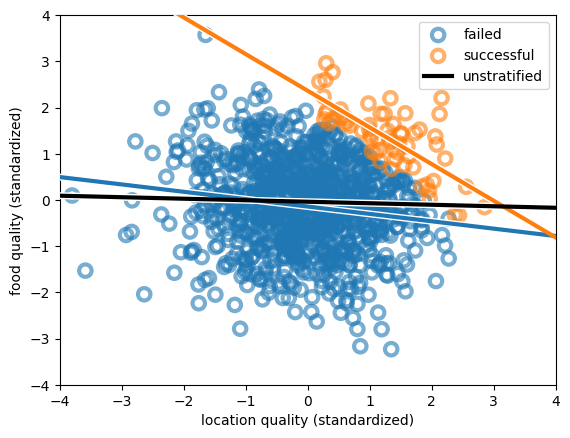

In [32]:
xs = np.linspace(-4, 4, 20)

for sib, label in enumerate(["business_failed", "business_succeeded"]):
    scatter_data = data[data.stays_in_business==sib]
    plot_scatter(
        scatter_data.location_quality,
        scatter_data.food_quality,
        color=f'C{sib}',
        label="successful" if sib else "failed"
    );

    plot_sms_restaurant_model_fit(models[label], xs, color=f'C{sib}', label=None)

plot_sms_restaurant_model_fit(models['unstratified'], xs, label='unstratified', color='black')

plt.xlabel("location quality (standardized)")
plt.ylabel("food quality (standardized)")

plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.legend();

By looking only at successful restaurants, we would mislead ourselves and infer that lower-quality locations have better food, when in fact there is no relationship between location and food quality.

## The Decendent
Takes on a **diluted behavior of the parent.**
- If the parent forms a Collider, the descendant acts as a weak collider. Same for Pipe and Fork descendants

## Discrete Example: Pipe Descendant
In this example the descendant branches off of a Pipe. Therefore we should observe the following:
- $X \not \perp Y$
- $X \perp Y | Z$
- $X \not \perp Y | A$, but correlation between X and Y should be reduced

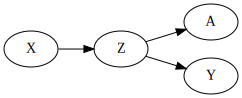

In [33]:
draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "A"),
        ("Z", "Y")
    ],
    graph_direction="LR"
)


$$
\begin{align*}
X &\sim \text{Bernoulli}(0.5) \\
Z &\sim \text{Bernoulli}(p^*) \\
A &\sim \text{Bernoulli}(q^*) \\
Y &\sim \text{Bernoulli}(r^*) \\
p^* &= .9 X + .1 (1 - X) \\
q^* &= .9 Z + .1 (1 - Z) \\
r^* &= .9 Z + .1 (1 - Z) \\
\end{align*}
$$


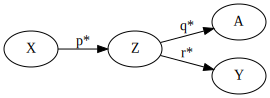

In [34]:
draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "A"),
        ("Z", "Y")
    ],
    edge_props={
        ("X", "Z"): {"label": "p*"},
        ("Z", "A"): {"label": "q*"},
        ("Z", "Y"): {"label": "r*"}
    },
    graph_direction="LR"
)

In [35]:
n_samples = 1000

X = stats.bernoulli.rvs(p=.5, size=n_samples)

p_star = .9 * X + .1 * (1 - X)
Z = stats.bernoulli.rvs(p=p_star, size=n_samples)

q_star = .9 * Z + .1 * (1 - Z)
A = stats.bernoulli.rvs(p=q_star, size=n_samples)

r_star = .9 * Z + .1 * (1 - Z)
Y = stats.bernoulli.rvs(p=r_star, size=n_samples)

Demonstrate that

- $X \not \perp Y$
- $X \perp Y | Z$


In [36]:
summarize_discrete_counfound_simulation(X, Y, A)

Correlation between X and Y: 0.71
Cross tabulation:
     X    Y
X  425   66
Y   79  430

Correlation between X and Y conditioned on Z=0: 0.43
Cross tabulation:
     X   Y
X  378  40
Y   42  45

Correlation between X and Y conditioned on Z=1: 0.53
Cross tabulation:
    X    Y
X  47   26
Y  37  385


## Discrete Example: Collider Descendant
In this example the descendant branches off of a Collider. Therefore we should observe the following:
- $X \perp Y$
- $X \not \perp Y | Z$
- $X \not \perp Y | A$

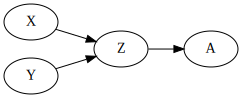

In [37]:
draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "A"),
        ("Y", "Z")
    ],
    graph_direction="LR"
)

$$
\begin{align*}
X &\sim \text{Normal}(0, 1) \\
Y &\sim \text{Normal}(0, 1) \\
Z &\sim \text{Bernoulli}(p^*) \\
A &\sim \text{Bernoulli}(q^*) \\
p^* &= \begin{cases}
    0.9 ,& \text{if } X + Y \gt 2\\
    0.1,              & \text{otherwise}
\end{cases} \\
q^* &= .05 Z + .95 (1 - Z)
\end{align*}
$$

In [38]:
n_samples = 1000

X = stats.norm.rvs(size=n_samples)
Y = stats.norm.rvs(size=n_samples)

p_star = np.where(X + Y > 2, .9, .1)
Z = stats.bernoulli.rvs(p=p_star, size=n_samples)

q_star = .95 * Z + .05 * (1 - Z)
A = stats.bernoulli.rvs(p=q_star, size=n_samples)

In [39]:
print(f'Correlation between X and Y: {np.corrcoef(X, Y)[0, 1]:1.2}')
for a in [0, 1]:
    print(f'Correlation between X and Y conditioned on A={a}: {np.corrcoef(X[A==a], Y[A==a])[0, 1]:1.2}')


Correlation between X and Y: 0.035
Correlation between X and Y conditioned on A=0: -0.081
Correlation between X and Y conditioned on A=1: 0.21


## Descendants are everywhere
- Many measurements are **proxies** for what we want to measure

## Unobserved Confounds
- Confounds are everywhere, and can ruin your day
- Some controls are better than others
- Often, trying to control for some variables can open up paths to unobserved confounds; we must always be aware of this possibility

# Confounds
## Review
- The Fork $X \leftarrow Z \rightarrow Y$
  - $X$ adn $Y$ are associated unless we stratify by $Z$
- The Pipe $X \rightarrow Z \rightarrow Y$
  - $X$ adn $Y$ are associated unless we stratify by $Z$
- The Fork $X \rightarrow Z \leftarrow Y$
  - $X$ adn $Y$ are not associated unless we stratify by $Z$
- The Descendant $Z \rightarrow A$
  - Descendent $A$ takes on behavior of parent $Z$


# Good and Bad Controls

# Confounds
## Review
- The Fork $X \leftarrow Z \rightarrow Y$
  - $X$ adn $Y$ are associated unless we stratify by $Z$
- The Pipe $X \rightarrow Z \rightarrow Y$
  - $X$ adn $Y$ are associated unless we stratify by $Z$
- The Fork $X \rightarrow Z \leftarrow Y$
  - $X$ adn $Y$ are not associated unless we stratify by $Z$
- The Descendant $Z \rightarrow A$
  - Descendent $A$ takes on behavior of parent $Z$


![Alt text](https://github.com/Gallifantjack/mit_causal_inference_intro/blob/dev/images/image_element_confounds.png?raw=1)

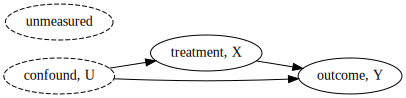

In [40]:
draw_causal_graph(
    edge_list=[
        ("U", "X"),
        ("U", "Y"),
        ("X", "Y")
    ],
    node_props={
        "X": {"label": "treatment, X"},
        "Y": {"label": "outcome, Y"},
        "U": {"label": "confound, U", "style": "dashed"},
        "unmeasured": {"style": "dashed"}
    },
    graph_direction="LR"
)

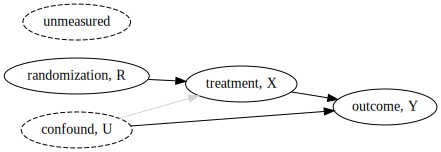

In [41]:
draw_causal_graph(
    edge_list=[
        ("U", "X"),
        ("U", "Y"),
        ("X", "Y"),
        ("R", "X")
    ],
    node_props={
        "X": {"label": "treatment, X"},
        "Y": {"label": "outcome, Y"},
        "U": {"label": "confound, U", "style": "dashed"},
        "R": {"label": "randomization, R"},
        "unmeasured": {"style": "dashed"}
    },
    edge_props={
        ("U", "X"): {"color": 'lightgray'}
    },
    graph_direction="LR"
)

The gold standard is **Randomization**. However randomization often this generally isn't possible:
- impossible
- pragmatism
- ethical concerns
- unmeasured confounds

## Causal Thinking
- We would like a procedure $do(X)$ that intervenes on $X$ in such a way that it can "mimic" the effect of randomization.
- Such a procedure would transform the Confounded graph:

#### Without randomization

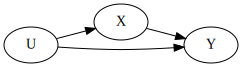

In [42]:
draw_causal_graph(
    [
        ("U", "X"),
        ("U", "Y"),
        ("X", "Y"),
    ],
    graph_direction="LR"
)

in such a way that all the non-causal arrows entering X have been removed

#### With "randomization" induced by $do(X)$

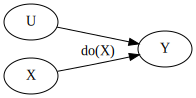

In [43]:
draw_causal_graph(
    [
        ("U", "Y"),
        ("X", "Y"),
    ],
    edge_props={
        ("X", "Y"): {"label": "do(X)   "}
    },
    graph_direction="LR"
)

It turns out that we can analyze graph structure to determine if there is such a procedure that exists

## Example: Simple Confound

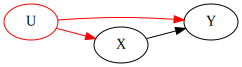

In [44]:
draw_causal_graph(
    edge_list=[
        ("U", "Y"),
        ("U", "X"),
        ("X", "Y")
    ],
    node_props={
        "U": {"color": "red"},
    },
    edge_props={
        ("U", "X"): {"color": "red"},
        ("U", "Y"): {"color": "red"}
    },
    graph_direction="LR"
)

In the Fork example, we've shown that stratifying by the confound, we "close" the fork by conditioning on U, thus removing any of the causal effect of U on X, thus allowing us to isolate the treatment's effect on Y.

This procedure is part of what is known as Do-calculus. The operator `do(X)` tends to mean intervening on X (i.e. setting it to a specific value that is independent of the confound)

$$
p(Y | do(X)) = \sum_U p(Y | X, U)p(U) = \mathbb{E}_U[p(Y | X, U)]
$$

i.e. **the procedure that gives us the intervention on X is equivalent of the distribution of Y, stratified by the treatment X and the confound X, averaged over the distribution of the confound.**

> Note that when we use linear regression estimator for each X, we are **implicity marginalizing and averaging** over out treatment and confound (e.g. in the model form $Y \sim \mathcal{N}(\alpha + \beta_X X + \beta_Z Z, \sigma^2)$

- it is generally **not the estimated coefficient** in the model that relate X to Y
- it is the distribution of Y when we change X, **averaged over the distribution** defined by the control/confound variables (i.e. U)

#### Example
- Cheetahs eat baboons and Gazelle
- Baboons therefore hide when cheetahs are present
- When cheetahs are absent, baboons no longer hide and become the main predatorof gazelle
-  So the causal effect of baboons on gazelle is dependant on distribution of Cheetahs
![](https://github.com/Gallifantjack/mit_causal_inference_intro/blob/dev/images/cheetah.png?raw=1)

## Do-calculus
- Applied to DAGs, provides a set of rules for identifying $p(Y | do(X))$
- **Informs what is possible** before picking functions or distributions
- **Justifies graphical analysis**
- If do-calculus claims that inference is possible no further special assumptions are required for inference
  - often additional assumptions can make the inference even stronger

## Backdoor Criterion
**Shortcut for applying Do-calculus graphically with your eyeballs.** General rule for finding the minimal sufficient adjustment set of variables to condition on.

1. Identify **all** paths connecting treatment X to to outcome Y, including those entering and exiting X (association can be directe/undirected, causation is directed)
2. Any of those paths **entering X** are backdoor (non-causal) paths
3. Find the **adjustment set** of variables that, once conditioned on, "closes/blocks" all the backdoor paths identified in

![Alt text](https://github.com/Gallifantjack/mit_causal_inference_intro/blob/dev/images/backdoor.png?raw=1)
#### Backdoor Criterion Example

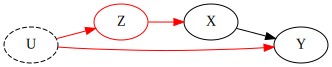

In [45]:
draw_causal_graph(
    [
        ("U", "Z"),
        ("Z", "X"),
        ("U", "Y"),
        ("X", "Y")
    ],
    node_props={
        "Z": {"color": "red"},
        "U": {"style": "dashed"}
    },
    edge_props={
        ("U", "Z"): {"color": "red"},
        ("Z", "X"): {"color": "red"},
        ("U", "Y"): {"color": "red"}
    },
    graph_direction="LR"

)

Backdoor path highlighted in red.

- If we could measure $U$ we could just stratify by $U$; however, it is unobserved.
- However, we can block the backdoor path by conditioning on $Z$, despite not being able to measure $U$.
- This works because $Z$ "knows" everything we need to know about association between $X$, $Y$ that is due to the unmeasured confound $U$.

#### Resulting graph after stratifying by $Z$
- The $U \rightarrow Z \rightarrow X$ Pipe has now been broken, disassociateing $X$ from the confound $U$
- Note: this doesn't remove the confound's effect on $Y$

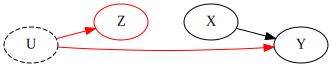

In [46]:
draw_causal_graph(
    [
        ("U", "Z"),
        ("Z", "X"),
        ("U", "Y"),
        ("X", "Y")
    ],
    node_props={
        "Z": {"color": "red"},
        "U": {"style": "dashed"}
    },
    edge_props={
        ("U", "Z"): {"color": "red"},
        ("Z", "X"): {"color": "none"},
        ("U", "Y"): {"color": "red"}
    },
    graph_direction="LR"

)

### Validate through simulation

Here we simulate a situation where Y is caused by X and and an unmeasured confound U that also effects Z and X. (We could also prove mathematically, but simulation is quite confincing as well--for me anyways)

$$
\begin{align*}
U &\sim \text{Bernoulli}(0.5) \\
Z &\sim \text{Normal}(\beta_{UZ}U, 1) \\
X &\sim \text{Normal}(\beta_{ZX}Z, 1) \\
Y &\sim \text{Normal}(\alpha + \beta_{XY}X + \beta_{UY}U, 1) \\
\end{align*}
$$

In [47]:
np.random.seed(123)
n_samples = 200

alpha = 0
beta_XY = 0
beta_UY = -1
beta_UZ = -1
beta_ZX = 1

U = stats.bernoulli.rvs(p=.5, size=n_samples)
Z = stats.norm.rvs(loc=beta_UZ * U)
X = stats.norm.rvs(loc=beta_ZX * Z)
Y = stats.norm.rvs(loc=alpha + beta_XY * X + beta_UY * U)

### Unstratified (confounded) Model


$$
\begin{align*}
Y &\sim \text{Normal}(\mu_Y, \sigma_Y) \\
\mu_Y &= \alpha + \beta_{XY}X \\
\alpha &\sim \text{Normal}(0, 1) \\
\beta_{XY} &\sim \text{Normal}(0, 1) \\
\sigma_Y &\sim \text{Exponential}(1)
\end{align*}
$$

#### Fit the unstratified model, ignoring Z (and U)

In [48]:
with pm.Model() as unstratified_model:
    # Priors
    alpha_ = pm.Normal("alpha", 0, 1)
    beta_XY_ = pm.Normal("beta_XY", 0, 1)
    sigma_ = pm.Exponential("sigma", 1)

    # Likelihood
    mu_ = alpha_ + beta_XY_ * X
    Y_ = pm.Normal("Y", mu=mu_, sigma=sigma_, observed=Y)
    unstratified_model_inference = pm.sample()

In [49]:
az.summary(unstratified_model_inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.382,0.086,-0.534,-0.210,0.002,0.001,1988.0,1437.0,1.0
beta_XY,0.147,0.052,0.041,0.234,0.001,0.001,2274.0,1564.0,1.0
sigma,1.115,0.056,1.017,1.227,0.001,0.001,2219.0,1526.0,1.0


### Stratifying by Z (unconfounded)


$$
\begin{align*}
Y &\sim \text{Normal}(\mu_Y, \sigma_Y) \\
\mu_Y = &\alpha + \beta_{XY}X + \beta_{Z}Z \\
\alpha &\sim \text{Normal}(0, 1) \\
\beta_{*} &\sim \text{Normal}(0, 1) \\
\sigma_Y &\sim \text{Exponential}(1)
\end{align*}
$$

In [50]:
# Fit the stratified Model
with pm.Model() as stratified_model:
    # Priors
    alpha_ = pm.Normal("alpha", 0, 1)
    beta_XY_ = pm.Normal("beta_XY", 0, 1)
    beta_Z_ = pm.Normal("beta_Z", 0, 1)
    sigma_ = pm.Exponential("sigma", 1)

    # Likelihood (includes Z)
    mu_ = alpha_ + beta_XY_ * X + beta_Z_ * Z
    Y_ = pm.Normal("Y", mu=mu_, sigma=sigma_, observed=Y)
    stratified_model_inference = pm.sample()

In [51]:
az.summary(stratified_model_inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.281,0.089,-0.437,-0.109,0.002,0.002,1717.0,1418.0,1.0
beta_XY,-0.026,0.079,-0.161,0.131,0.002,0.002,1614.0,1307.0,1.0
beta_Z,0.320,0.107,0.126,0.523,0.003,0.002,1564.0,1227.0,1.0
sigma,1.091,0.057,0.992,1.197,0.001,0.001,2020.0,1119.0,1.0


**NOTE**: the model coefficient `beta_Z` means nothing in in terms of causal effect of $Z$ on $Y$. In order to determine the causal effect of $Z$ on $Y$ you'd need a different estimator. In general, variables in the adjustment set are not interpretable. This is related to the "Table 2 Fallacy"

#### Compare stratified and unstratified models

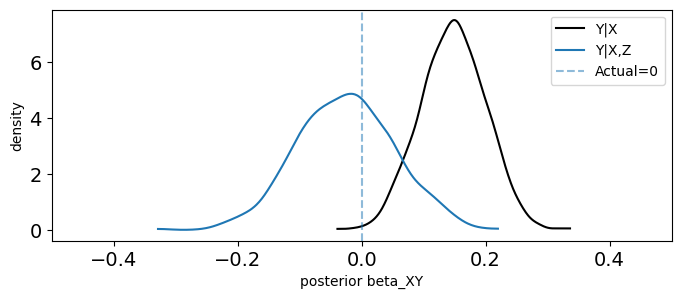

In [52]:
_, ax = plt.subplots(figsize=(8, 3))
az.plot_dist(unstratified_model_inference.posterior.beta_XY, color='k', label='Y|X', ax=ax)
az.plot_dist(stratified_model_inference.posterior.beta_XY, color='C0', label='Y|X,Z', ax=ax)
plt.axvline(beta_XY, color='C0', linestyle='--', alpha=.5, label=f"Actual={beta_XY}")
plt.xlim([-.5, .5])
plt.xlabel("posterior beta_XY")
plt.ylabel("density")
plt.legend();

## More Complicated Example

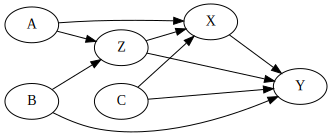

In [53]:
draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    graph_direction="LR"
)


### All Paths Connecting X to Y

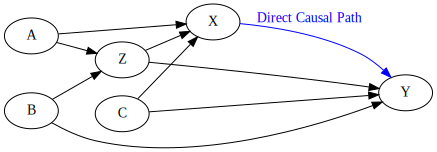

In [54]:
draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    edge_props={
        ("X", "Y"): {"color": "blue", "label": "Direct Causal Path", "fontcolor": "blue"},
    },
    graph_direction="LR"
)

#### $X \rightarrow Y$
- Direct, causal path, leave open

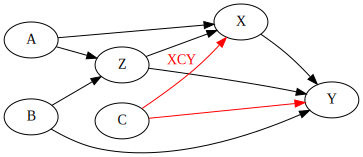

In [55]:
draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    edge_props={
        ("C", "X"): {"color": "red", "label": "XCY", "fontcolor": "red"},
        ("C", "Y"): {"color": "red"},
    },
    graph_direction="LR"
)

#### $X \leftarrow C \rightarrow Y$
- Backdoor non-causal path
- Block by **stratifying by $C$**

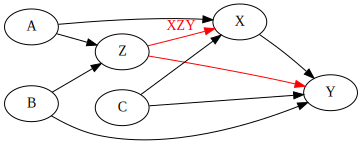

In [56]:
draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    edge_props={
        ("Z", "X"): {"color": "red", "label": "XZY", "fontcolor": "red"},
        ("Z", "Y"): {"color": "red"},
    },
    graph_direction="LR"
)

#### $X \leftarrow Z \rightarrow Y$
- Backdoor non-causal path
- Block by **stratifying by $Z$**

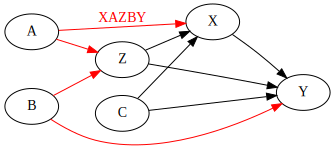

In [57]:
draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    edge_props={
        ("A", "X"): {"color": "red", "label": "XAZBY", "fontcolor": "red"},
        ("A", "Z"): {"color": "red"},
        ("B", "Z"): {"color": "red"},
        ("B", "Y"): {"color": "red"},

    },
    graph_direction="LR"
)

#### $X \leftarrow A \rightarrow Z \leftarrow B \rightarrow Y$
- Backdoor non-causal path
- Block by **stratifying by $A$ or $B$**; stratifying by $Z$ opens the path b.c. it's a collider
  - we're already stratifying by $Z$ for the $X,Z,Y$ backdoor path

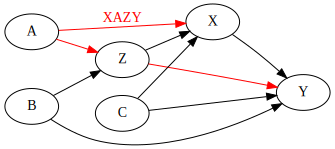

In [58]:
draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    edge_props={
        ("A", "X"): {"color": "red", "label": "XAZY", "fontcolor": "red"},
        ("A", "Z"): {"color": "red"},
        ("Z", "Y"): {"color": "red"},
        ("Z", "Y"): {"color": "red"},

    },
    graph_direction="LR"
)

#### $X \leftarrow A \rightarrow Z \rightarrow Y$
- Backdoor non-causal path
- Block by **stratifying by $A$;** stratifying by $Z$ opens the path b.c. it's a collider
  - we're already stratifying by $Z$ for the $X \leftarrow Z \rightarrow Y$ backdoor path

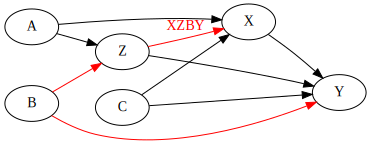

In [59]:
draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    edge_props={
        ("Z", "X"): {"color": "red", "label": "XZBY", "fontcolor": "red"},
        ("B", "Z"): {"color": "red"},
        ("B", "Y"): {"color": "red"},
    },
    graph_direction="LR"
)

#### $X \leftarrow Z \leftarrow B \rightarrow Y$
- Backdoor non-causal path
- Block by **stratifying by $B$**; stratifying by $Z$ opens the path b.c. it's a collider
  - we're already stratifying by $Z$ for the $X \leftarrow Z \rightarrow Y$ backdoor path

![Alt text](https://github.com/Gallifantjack/mit_causal_inference_intro/blob/dev/images/backdoor-examples.png?raw=1)

#### Resulting Minimum Adjustment set: Z, C, (A or B)
Chossing B over A turns out to be more statistically efficient, though not causally different than choosing A

**Try this yourself at [Daggity](www.dagitty.net)**

## Example with unobserved confounds

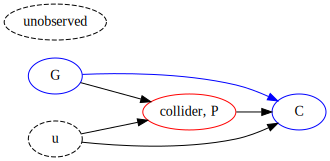

In [60]:
draw_causal_graph(
    edge_list=[
        ("G", "P"),
        ("P", "C"),
        ("G", "C"),
        ("u", "P"),
        ("u", "C")
    ],
    node_props={
        "G": {"color": "blue"},
        "C": {"color": "blue"},
        "P": {"color": "red", "label": "collider, P"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },
    edge_props={
        ("G", "C"): {"color": "blue"}
    },
    graph_direction="LR"
)

- $P$ is mediator between $G$ and $C$
- $P$ is also a collider between $G, u, C$
- If we want to estimate direct effect of $G \rightarrow C$, we'll need to stratify by $P$--close the Pipe
- However, this will open up the Collider path to the unobserved confound.
- **It's not possible to accurately estimate the _Direct Causal Effect_ of G on C**
- It **is possible to estimate the _Total Causal Effect_**

![Alt text](https://github.com/Gallifantjack/mit_causal_inference_intro/blob/dev/images/identifiability.png?raw=1)

# Good and bad controls

## Common _incorrect_ heuristics for choosing control variables:

- YOLO approach -- anything in the spreadsheet
- Ignore highly colinear variables
  - false, no support for this
  - colinearity can arise through many different causal processes that _can be modeled accurately_
- It's safe to add pre-treatment variables
  - false, pre-treatment, just like post-treatment variables can cause confounds.

## Good & Bad Controls Examples

### Bad control

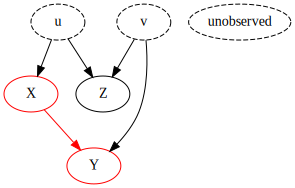

In [61]:
draw_causal_graph(
    edge_list=[
        ("u", "Z"),
        ("v", "Z"),
        ("u", "X"),
        ("X", 'Y'),
        ("v", "Y")
    ],
    node_props={
        "u": {"style": "dashed"},
        "v": {"style": "dashed"},
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("X", "Y"): {"color": "red"}
    },
    graph_direction="TD"
)

$Z$ is a collider for unobserved variables $u$ and $v$, which independently affect $X$ and $Y$
#### List the paths
- $X \rightarrow Y$
  - causal, leave open
- $X \leftarrow u \rightarrow Z \leftarrow v \rightarrow Y$
  - backdoor, closed due to collider
  - $Z$ is a **bad control**: stratifying by $Z$ would open the backdoor path
  - $Z$ could be a pre-treatment variable -- not always good to stratify by pre-treatment variables; **draw your causal assumptions**

### Bad mediator

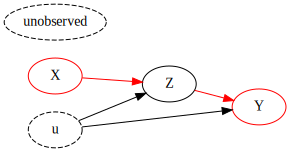

In [62]:
draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "Y"),
        ("u", "Z"),
        ("u", "Y"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("X", "Z"): {"color": "red"},
        ("Z", "Y"): {"color": "red"}
    },
    graph_direction='LR'
)

#### List the paths
- $X \rightarrow Z \rightarrow Y$
  - causal, leave open
- $X \rightarrow Z \leftarrow u \rightarrow Y$
  - backdoor, but only if stratifying by Z
- There **is no backdoor path, so no need to stratify by Z**
- Can measure total effect of $X$ on $Y$, but not direct effect, because of Mediatior $Z$

No backdoor path here, so no need to control for any confounds. In fact, stratifying by `Z` (the bad mediator) will introduce bias in estimate because it introduces the causal effect of `u` that would otherwise be blocked.

`Z` is often a post-treatment variable, e.g. below, where "Happiness" is affected by the treatment "Win Lottery"

### Verify bad mediatior with simulation:

![Alt text](https://github.com/Gallifantjack/mit_causal_inference_intro/blob/dev/images/bad_control.png?raw=1)

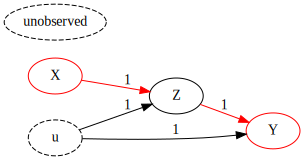

In [63]:
draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "Y"),
        ("u", "Z"),
        ("u", "Y"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("X", "Z"): {"color": "red", "label": "1"},
        ("Z", "Y"): {"color": "red", "label": "1"},
        ("u", "Z"): {"label": "1"},
        ("u", "Y"): {"label": "1"}
    },
    graph_direction='LR'
)

In [64]:
def simulate_bad_mediator(beta_XZ, beta_ZY, n_samples=100):
    # independent variables
    u = stats.norm.rvs(size=n_samples)
    X = stats.norm.rvs(size=n_samples)

    # causal effect of X on Z
    mu_Z = X * beta_XZ + u
    Z = stats.norm.rvs(size=n_samples, loc=mu_Z)

    # Causal effect of Z on Y (including confound)
    mu_Y = Z * beta_ZY + u
    Y = stats.norm.rvs(size=n_samples, loc=mu_Y)

    # Put data into format for statsmodels
    data = pd.DataFrame(np.vstack([Y, X, Z, u]).T, columns=["Y", "X", "Z", "u"])

    unstratified_model = smf.ols("Y ~ X", data=data).fit()
    stratified_model = smf.ols("Y ~ X + Z", data=data).fit()

    return unstratified_model.params.X, stratified_model.params.X

def run_bad_mediator_simulation(beta_XZ=1, beta_ZY=1, n_simulations=500, n_samples_per_simualtion=100):
    beta_X = beta_XZ * beta_ZY

    simulations = np.array(
        [
            simulate_bad_mediator(beta_XZ=beta_XZ, beta_ZY=beta_ZY, n_samples=n_samples_per_simualtion)
            for _ in range(n_simulations)
        ]
    )
    _, ax = plt.subplots(figsize=(8, 4))
    az.plot_dist(simulations[:, 0], label='Y ~ X\ncorrect', color='black', ax=ax)
    az.plot_dist(simulations[:, 1], label='Y ~ X + Z\nwrong', color="C0", ax=ax)
    plt.axvline(beta_X, color='k', linestyle='--', label=f'actual={beta_X}')
    plt.legend(loc='upper left')
    plt.xlabel("posterior mean")
    plt.ylabel("density");

#### Run the simulation, $\beta_{XZ} = \beta_{ZY} = 1$

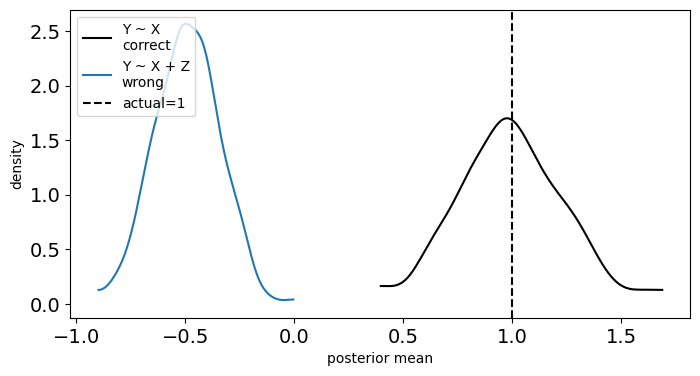

In [65]:
run_bad_mediator_simulation(beta_XZ=1, beta_ZY=1)

#### Post Treatment stratification error
![Alt text](https://github.com/Gallifantjack/mit_causal_inference_intro/blob/dev/image-25.png?raw=1)

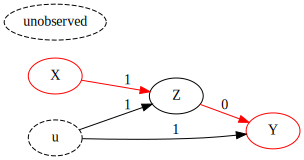

In [66]:
draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "Y"),
        ("u", "Z"),
        ("u", "Y"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("X", "Z"): {"color": "red", "label": "1"},
        ("Z", "Y"): {"color": "red", "label": "0"},
        ("u", "Z"): {"label": "1"},
        ("u", "Y"): {"label": "1"}
    },
    graph_direction='LR'
)

#### Turn off Causal effect by changing $\beta_{ZY}$ to 0

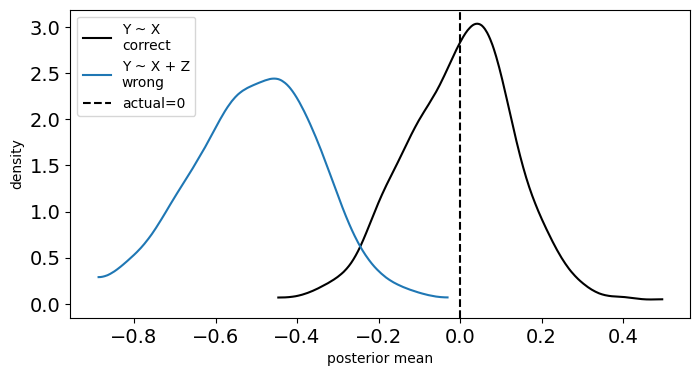

In [67]:
run_bad_mediator_simulation(beta_XZ=1, beta_ZY=0)

though there is no causal effect, you end up concluding a negative effect of X on Y

## Colliders & Descendants

Generally, **Avoid the Collider**!

Adding descendants of the target variable is almost always a terrible idea, because your selecting groups based on the outcome. This is known as **Case Control Bias** (selection on outcome)

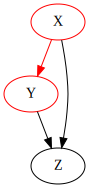

In [68]:
draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("X", "Z"),
        ("Y", "Z")
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"}
    },
    edge_props={
        ("X", "Y"): {"color": "red"}
    }
)

**Colliders not always so obvious**

![Alt text](https://github.com/Gallifantjack/mit_causal_inference_intro/blob/dev/images/colliders_hidden.png?raw=1)

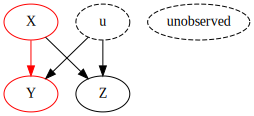

In [69]:
draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("X", "Z"),
        ("u", "Y"),
        ("u", "Z"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },
    edge_props={
        ("X", "Y"): {"color": "red"}
    }
)

Collider is formed by unobserved variable u

### Bad Descendent: Selection on Outcome (Case Control Bias)

Stratifying on a variable affected by the outcome is a **very bad** practice.
- reduces variation in $Y$ that could have been explained by $X$


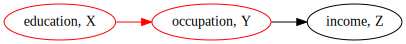

In [70]:
draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("Y", "Z"),
    ],
    node_props={
        "X": {"color": "red", "label": "education, X"},
        "Y": {"color": "red", "label": "occupation, Y"},
        "Z": {"label": "income, Z"},
    },
    edge_props={
        ("X", "Y"): {"color": "red"}
    },
    graph_direction="LR"
)

#### Verify via simulation:

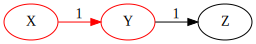

In [71]:
draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("Y", "Z"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
    },
    edge_props={
        ("X", "Y"): {"color": "red", "label": "1"},
        ("Y", "Z"): {"label": "1"}
    },
    graph_direction="LR"
)

In [72]:
def simulate_case_control_bias(beta_XY=1, beta_YZ=1, n_samples=100):
    # independent variables
    X = stats.norm.rvs(size=n_samples)

    # Causal effect of Z on Y (including confound)
    mu_Y = X * beta_XY
    Y = stats.norm.rvs(size=n_samples, loc=mu_Y)

    # causal effect of X on Z
    mu_Z = Y * beta_YZ
    Z = stats.norm.rvs(size=n_samples, loc=mu_Z)


    # Put data into format for statsmodels
    data = pd.DataFrame(np.vstack([Y, X, Z]).T, columns=["Y", "X", "Z"])

    unstratified_model = smf.ols("Y ~ X", data=data).fit()
    stratified_model = smf.ols("Y ~ X + Z", data=data).fit()

    return unstratified_model.params.X, stratified_model.params.X

def run_case_control_simulation(beta_XY=1, beta_YZ=1, n_simulations=500, n_samples_per_simualtion=100):
    beta_X = beta_XY

    simulations = np.array(
        [
            simulate_case_control_bias(beta_XY=beta_XY, beta_YZ=beta_YZ, n_samples=n_samples_per_simualtion)
            for _ in range(n_simulations)
        ]
    )
    _, ax = plt.subplots(figsize=(8, 4))
    az.plot_dist(simulations[:, 0], label='Y ~ X\ncorrect', color='black', ax=ax)
    az.plot_dist(simulations[:, 1], label='Y ~ X + Z\nwrong', color="C0", ax=ax)
    plt.axvline(beta_X, color='k', linestyle='--', label=f'actual={beta_X}')
    plt.legend(loc='upper left')
    plt.xlabel("posterior mean")
    plt.ylabel("density");

#### Descendant explains away some of he causal effect of $X$ on $Y$
The estimated causal effect has been reduced because the descendent reduces the variation in $Y$ that can can be explained by $X$

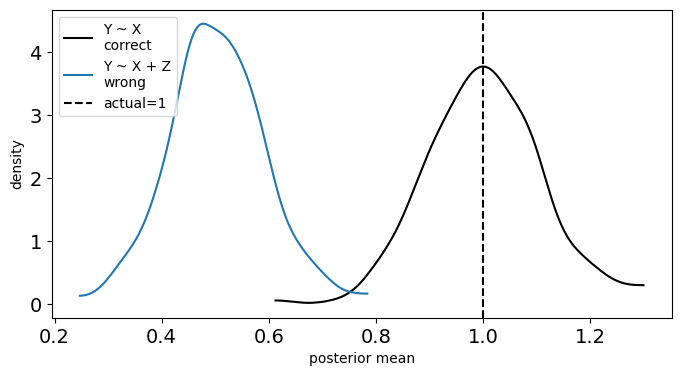

In [73]:
run_case_control_simulation(beta_XY=1, beta_YZ=1)

### Removing Descendent effect by setting $\beta_{YZ}=0$
The descendant no longer has any effect here, so we should recover the same (correct) inference for both stratified and unstratified models

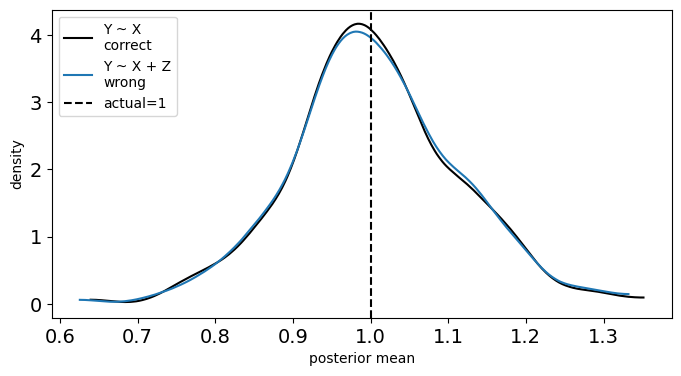

In [74]:
run_case_control_simulation(beta_XY=1, beta_YZ=0)

### Bad Ancestor (aka precision parasite)

Now $Z$ is a parent of $X$

- no backdoor path, $X$ is directly connected to $Y$
- when stratifying by $Z$ you're explaining away variation in $X$, thus reducing the amount of causal information between $X$ and $Y$ that can be explained otherwise.
- **Does not bias your estimate,** but it  **reduces precision**, so estimates will have more uncertainty

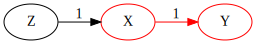

In [75]:
draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("Z", "X"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
    },
    edge_props={
        ("X", "Y"): {"color": "red", "label": "1"},
        ("Z", "X"): {"label": "1"}
    },
    graph_direction="LR"
)

#### Verify via simulation

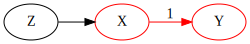

In [76]:
draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("Z", "X"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
    },
    edge_props={
        ("X", "Y"): {"color": "red", "label": "1"},
        ("Y", "Z"): {"color": "red", "label": "1"}
    },
    graph_direction="LR"
)

In [77]:
np.random.seed(123)
def simulate_bad_ancestor(beta_ZX=1, beta_XY=1, unobserved_variance=None, n_samples=100):
    Z = stats.norm.rvs(size=n_samples)

    mu_X = Z * beta_ZX
    if unobserved_variance is not None:
        u = stats.norm.rvs(size=n_samples) * unobserved_variance
        mu_X += u

    X = stats.norm.rvs(size=n_samples, loc=mu_X)

    mu_Y = X * beta_XY
    if unobserved_variance is not None:
        mu_Y += u

    Y = stats.norm.rvs(size=n_samples, loc=mu_Y)

    data = pd.DataFrame(np.vstack([X, Y, Z]).T, columns=['X', 'Y', 'Z'])

    non_stratified_model = smf.ols("Y ~ X", data=data).fit()
    stratified_model = smf.ols("Y ~ X + Z", data=data).fit()

    return non_stratified_model.params.X, stratified_model.params.X


def run_bad_ancestor_simulation(beta_ZX=1, beta_XY=1, n_simulations=500, unobserved_variance=None, n_samples_per_simualtion=100):
    beta_X = beta_XY

    simulations = np.array(
        [
            simulate_bad_ancestor(
                beta_ZX=beta_ZX,
                beta_XY=beta_XY,
                unobserved_variance=unobserved_variance,
                n_samples=n_samples_per_simualtion
            )
            for _ in range(n_simulations)
        ]
    )
    _, ax = plt.subplots(figsize=(8, 4))
    az.plot_dist(simulations[:, 0], label='Y ~ X\ncorrect', color='black', ax=ax)
    az.plot_dist(simulations[:, 1], label='Y ~ X + Z\nwrong', color="C0", ax=ax)
    plt.axvline(beta_X, color='k', linestyle='--', label=f'actual={beta_X}')
    plt.legend(loc='upper left')
    plt.xlabel("posterior mean")
    plt.ylabel("density");

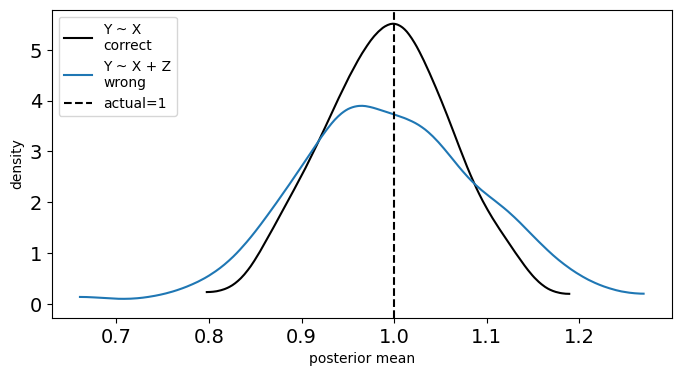

In [78]:
run_bad_ancestor_simulation()

Stratifying by Z doesn't add bias (it's centered on the correct value), but it does increase variance in estimator. This reduction in precision is proportional to the magnitude of the causal relationship between Z and X

#### Increasing the relationship between Z and X further reduces precicision

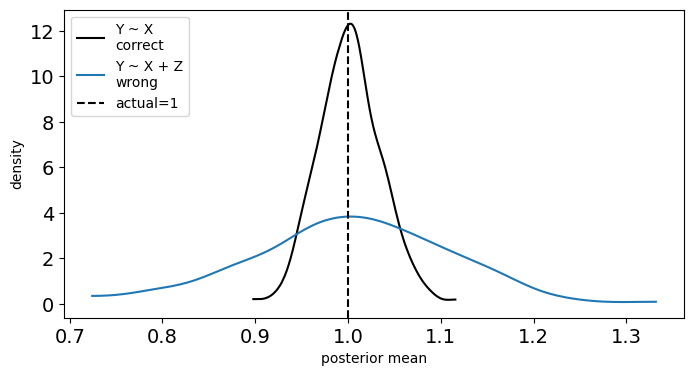

In [79]:
run_bad_ancestor_simulation(beta_ZX=3)

## Bias Amplification

Stratifying on an ancestor when there are other confounders, particularly unobserved forks. **This is like the Bias Parasite scenario, but it also adds bias.**

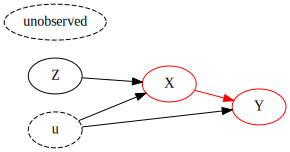

In [80]:
draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("Z", "X"),
        ("u", "X"),
        ("u", "Y")
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("X", "Y"): {"color": "red"},
        ("Y", "Z"): {"color": "red"}
    },
    graph_direction="LR"
)

### Verify via simulation

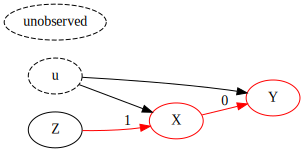

In [81]:
draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("Z", "X"),
        ("u", "X"),
        ("u", "Y")
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("X", "Y"): {"color": "red", "label": "0"},
        ("Z", "X"): {"color": "red", "label": "1"}
    },
    graph_direction="LR"
)

#### Run simulation with no actual causal effect, $\beta_{XY} = 0$

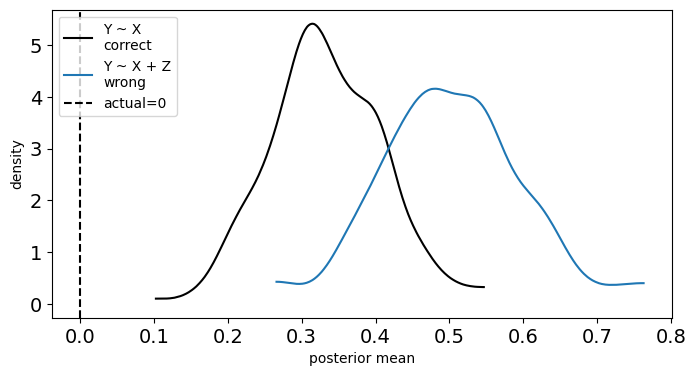

In [82]:
run_bad_ancestor_simulation(beta_ZX=1, beta_XY=0, unobserved_variance=1)

Above we see that both estimators are biased -- even in the best case, we can't observe, and thus control for the the confound $u$. But when stratifying by the ancestor, things are MUCH WORSE.

Hand-wavy explanation:
- in order for $X$ and $Y$ to be associated, their causes need to be associated
- by stratifying by $Z$, we remove the amount of variation in $X$ that is caused by $Z$
- this reduction in variation in $X$ makes the confound $u$ more important comparatively



### Discrete example of bias amplificiation

In [83]:
def simulate_discrete_bias_amplifications(beta_ZX=1, beta_XY=1, n_samples=1000):
    Z = stats.bernoulli.rvs(p=0.5, size=n_samples)
    u = stats.norm.rvs(size=n_samples)

    mu_X = beta_ZX * Z + u
    X = stats.norm.rvs(loc=mu_X, size=n_samples)

    mu_Y = X * beta_XY + u
    Y = stats.norm.rvs(loc=mu_Y, size=n_samples)

    data = pd.DataFrame(np.vstack([u, Z, X, Y]).T, columns=['u', 'Z', 'X', 'Y'])

    models = {}
    models['unstratified'] = smf.ols("Y ~ X", data=data).fit()
    models['z=0'] = smf.ols("Y ~ X", data=data[data.Z == 0]).fit()
    models['z=1'] = smf.ols("Y ~ X", data=data[data.Z == 1]).fit()

    return models, data

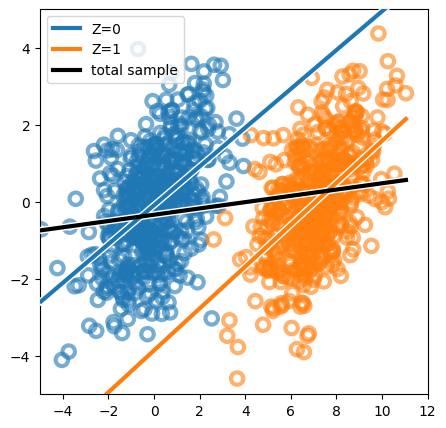

In [84]:
beta_ZX = 7
beta_ZY = 0
models, data = simulate_discrete_bias_amplifications(beta_ZX=beta_ZX, beta_XY=beta_XY)

fig, axs = plt.subplots(figsize=(5, 5))

def plot_linear_model(model, color, label):
    params = model.params
    xs = np.linspace(data.X.min(), data.X.max(), 10)
    ys = params.Intercept + params.X * xs
    plot_line(xs, ys, color=color, label=label)

for z in [0, 1]:
    color = f'C{z}'
    plot_scatter(data.X[data.Z==z], data.Y[data.Z==z], color=color)
    model = models[f"z={z}"]
    plot_linear_model(model, color=color, label=f"Z={z}")

model = models['unstratified']
plot_linear_model(model, color="k", label=f"total sample")

plt.xlim([-5, 12])
plt.ylim([-5, 5])

plt.legend();


- When ignoring Z (the ancestor), the estimate is still somewhat biased (i.e. the black slope is not flat, as it shoudl be for $\beta_{XY}=0$)
- but it's not nearly as bad as the individual slopes (blue/red) when stratifying by Z.

# Review: Good & Bad Controls
- **Confound**: estimator design or sample that "confoudnds" or "confuses" our causal estiamte
- **Control**: variable added to the analysis to that a causal estimate is possible
- Adding controls can often be worse than ommitting them
- Make assumptions explicit, and use backdoor criterion to verify those assumptions

**You have to do scientific modeling to do scientific analysis**

## Now go here

(Causal thinking for decision making on Electronic Health Records: why and how, Doutreligne M. and Struja T. and Abecassis J. and Morgand C. and Celi L. and Varoquaux G., arXiv preprint arXiv:2308.01605, 2023)[https://arxiv.org/abs/2308.01605]